# Algoritmos de ML para Classificação: Tuning dos Hiperparâmetros e Seleção de Variáveis

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Função de Métricas de Avaliação

In [2]:
def show_results(y,y_pred):
    # Calcular os resultados
    cm = confusion_matrix(y, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm) # False positive
    FN = cm.sum(axis=1) - np.diag(cm) # False negative
    TP = np.diag(cm) # true prositive
    TN = cm.sum() - (FP + FN + TP) # true negative
    TPR = TP/(TP+FN) # Sensitividade / Recall
    TNR = TN/(TN+FP) # Especificidade
    PPV = TP/(TP+FP) # Precisao
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1 = 2*((PPV*TPR)/(PPV+TPR))
    ACC = (TP+TN)/(TP+FP+FN+TN) # Acurácia
    
    # Exibe resultados
    print("    True Positives:{}".format(TP))
    print("    True Negatives:{}".format(TN))
    print("    False Positives:{}".format(FP))
    print("    False Negatives:{}".format(FN))
    print("    Sensibilidade / Recall:{}".format(TPR))
    print("    Especificidade:{}".format(TNR))
    print("    Precisao:{}".format(PPV))
    print("    Negative predictive value:{}".format(NPV))
    print("    Fall out:{}".format(FPR))
    print("    False negative rate:{}".format(FNR))
    print("    False discovery rate:{}".format(FDR))
    print("    F1 Score:{}".format(F1))
    print("    Acuracia:{}".format(ACC))
    print("    CONFUSION MATRIX ------------")
    print("    {}".format(cm))

## Base de Dados

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

df_base = pd.DataFrame(data=features, columns=feature_names)
df_base.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Descritivas - Resposta

In [4]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 212, 1: 357}

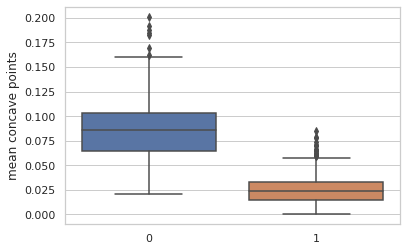

In [5]:
ax = sns.boxplot(x=labels, y=df_base['mean concave points'])

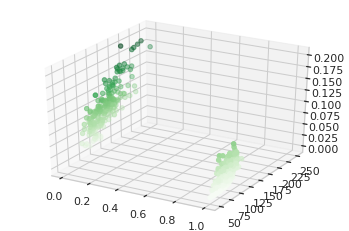

In [6]:
ax = plt.axes(projection='3d')

zdata = df_base['mean concave points']
xdata = labels
ydata = df_base['worst perimeter']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
plt.show()

## Treino / Teste

In [7]:
from sklearn.model_selection import train_test_split

y = labels
X = df_base.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

## KNN

### Melhores Hiperparâmetros

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
hyperparameters = dict(n_neighbors=[3,5,7,9], weights=['uniform', 'distance'],
                      algorithm= ['auto', 'ball_tree', 'kd_tree', 'brute'],
                      metric=['minkowski', 'euclidean', 'manhattan'])

randomizedsearch = RandomizedSearchCV(knn, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
knn_best = randomizedsearch.fit(X_train, y_train)
print(knn_best.best_params_) # Melhores hiperparâmetros

{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'auto'}


### Avaliação

In [9]:
y_pred = knn_best.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 57 104]
    True Negatives:[104  57]
    False Positives:[4 6]
    False Negatives:[6 4]
    Sensibilidade / Recall:[0.9047619  0.96296296]
    Especificidade:[0.96296296 0.9047619 ]
    Precisao:[0.93442623 0.94545455]
    Negative predictive value:[0.94545455 0.93442623]
    Fall out:[0.03703704 0.0952381 ]
    False negative rate:[0.0952381  0.03703704]
    False discovery rate:[0.06557377 0.05454545]
    F1 Score:[0.91935484 0.95412844]
    Acuracia:[0.94152047 0.94152047]
    CONFUSION MATRIX ------------
    [[ 57   6]
 [  4 104]]


In [10]:
balanced_accuracy_score(y_test, y_pred)

0.9338624338624338

## Naive Bayes

### Melhores Hiperparâmetros

In [11]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
hyperparameters = dict(priors=[(0.5, 0.5), (0.4, 0.6), (0.35, 0.65)])

randomizedsearch = RandomizedSearchCV(nb, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
nb_best = randomizedsearch.fit(X_train, y_train)
print(nb_best.best_params_) # Melhores hiperparâmetros

{'priors': (0.4, 0.6)}


### Avaliação

In [12]:
y_pred = nb_best.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 57 101]
    True Negatives:[101  57]
    False Positives:[7 6]
    False Negatives:[6 7]
    Sensibilidade / Recall:[0.9047619  0.93518519]
    Especificidade:[0.93518519 0.9047619 ]
    Precisao:[0.890625   0.94392523]
    Negative predictive value:[0.94392523 0.890625  ]
    Fall out:[0.06481481 0.0952381 ]
    False negative rate:[0.0952381  0.06481481]
    False discovery rate:[0.109375   0.05607477]
    F1 Score:[0.8976378  0.93953488]
    Acuracia:[0.92397661 0.92397661]
    CONFUSION MATRIX ------------
    [[ 57   6]
 [  7 101]]


In [13]:
balanced_accuracy_score(y_test, y_pred)

0.919973544973545

## Logistic Regression

### Melhores Hiperparâmetros

In [14]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
hyperparameters = dict(penalty=['l1', 'l2', 'elasticnet', 'none'], C=[1, 0.9, 0.5, 0.1, 0.01],
                      fit_intercept=[True, False], class_weight=['balanced', None],
                      solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

randomizedsearch = RandomizedSearchCV(logis, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
logis_best = randomizedsearch.fit(X_train, y_train)
print(logis_best.best_params_) # Melhores hiperparâmetros

{'solver': 'newton-cg', 'penalty': 'none', 'fit_intercept': False, 'class_weight': None, 'C': 0.9}


### Seleção de Variáveis

In [15]:
logis_best = LogisticRegression(random_state=0, solver='newton-cg', penalty='none', fit_intercept=False, 
                         class_weight=None, C=0.9)

model = RFECV(estimator=logis_best, step=1, cv=StratifiedKFold(5), scoring='balanced_accuracy', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 30


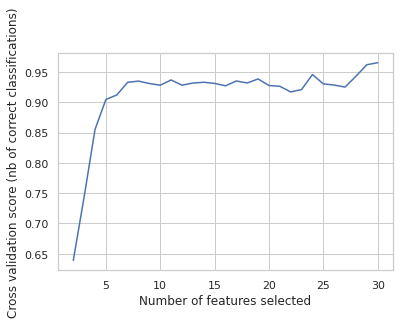

In [16]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

In [17]:
# Variáveis Selecionadas
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)
X_train2.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [18]:
# Coeficientes
model.estimator_.coef_

array([[ 1.08744531e+01, -2.69719930e-01, -1.12901252e+00,
        -9.60512161e-03, -1.80290257e+01,  3.11699070e+01,
        -1.27548935e+00, -4.61734958e+01, -1.56344907e+01,
         5.77299803e+00, -9.28342353e+00,  1.70473664e+00,
         6.63857293e-02, -1.71678005e-01,  7.24392789e-01,
         6.23317620e+01,  5.50243202e+01, -3.91448438e+00,
         1.18357733e+01,  1.41342851e+01,  1.40266848e+00,
        -2.68972061e-01,  4.42912235e-02, -4.54174765e-02,
        -2.06381454e+01,  2.00822340e+01, -2.16643294e+01,
        -8.40595330e+01, -9.51893622e+00, -3.07113412e+00]])

In [19]:
model.estimator_.intercept_

array([0.])

### Avaliação

In [20]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 59 104]
    True Negatives:[104  59]
    False Positives:[4 4]
    False Negatives:[4 4]
    Sensibilidade / Recall:[0.93650794 0.96296296]
    Especificidade:[0.96296296 0.93650794]
    Precisao:[0.93650794 0.96296296]
    Negative predictive value:[0.96296296 0.93650794]
    Fall out:[0.03703704 0.06349206]
    False negative rate:[0.06349206 0.03703704]
    False discovery rate:[0.06349206 0.03703704]
    F1 Score:[0.93650794 0.96296296]
    Acuracia:[0.95321637 0.95321637]
    CONFUSION MATRIX ------------
    [[ 59   4]
 [  4 104]]


In [21]:
balanced_accuracy_score(y_test, y_pred)

0.9497354497354498

## Decision Tree

### Melhores Hiperparâmetros

In [22]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
hyperparameters = dict(criterion=['gini', 'entropy'], splitter=['best', 'random'], max_depth=[50, 100, 200])

randomizedsearch = RandomizedSearchCV(tree, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
tree_best = randomizedsearch.fit(X_train, y_train)
print(tree_best.best_params_) # Melhores hiperparâmetros

{'splitter': 'random', 'max_depth': 200, 'criterion': 'entropy'}


### Seleção de Variáveis

In [23]:
tree_best = DecisionTreeClassifier(random_state=0, splitter='random', max_depth=200, criterion='entropy')

model = RFECV(estimator=tree_best, step=1, cv=StratifiedKFold(5), scoring='balanced_accuracy', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 21


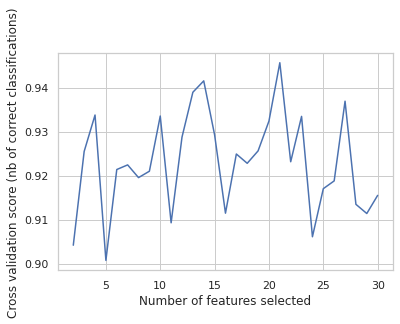

In [24]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

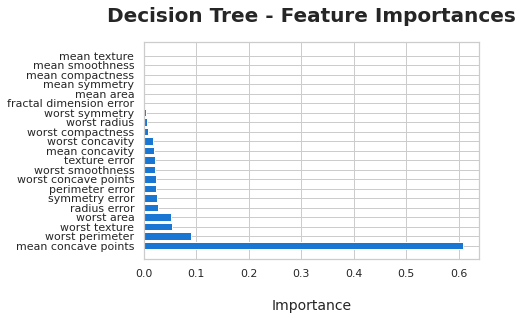

In [25]:
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['attr'] = X_train2.columns
dset['importance'] = model.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Decision Tree - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Avaliação

In [26]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 61 101]
    True Negatives:[101  61]
    False Positives:[7 2]
    False Negatives:[2 7]
    Sensibilidade / Recall:[0.96825397 0.93518519]
    Especificidade:[0.93518519 0.96825397]
    Precisao:[0.89705882 0.98058252]
    Negative predictive value:[0.98058252 0.89705882]
    Fall out:[0.06481481 0.03174603]
    False negative rate:[0.03174603 0.06481481]
    False discovery rate:[0.10294118 0.01941748]
    F1 Score:[0.93129771 0.95734597]
    Acuracia:[0.94736842 0.94736842]
    CONFUSION MATRIX ------------
    [[ 61   2]
 [  7 101]]


In [27]:
balanced_accuracy_score(y_test, y_pred)

0.9517195767195767

## Random Forest

### Melhores Hiperparâmetros

In [28]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
hyperparameters = dict(criterion=['gini', 'entropy'], n_estimators=[50,100,200], max_depth=[50, 100, 200],
                      class_weight=['balanced', 'balanced_subsample', None])

randomizedsearch = RandomizedSearchCV(tree, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
tree_best = randomizedsearch.fit(X_train, y_train)
print(tree_best.best_params_) # Melhores hiperparâmetros

{'n_estimators': 200, 'max_depth': 200, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


### Seleção de Variáveis

In [29]:
tree_best = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=200, criterion='gini',
                                  class_weight='balanced_subsample')

model = RFECV(estimator=tree_best, step=1, cv=StratifiedKFold(5), scoring='balanced_accuracy', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 28


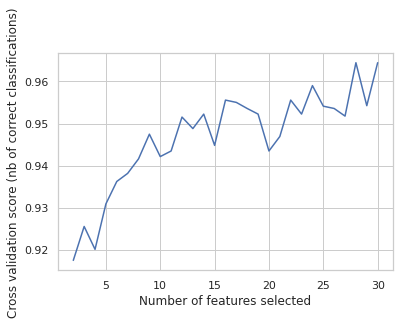

In [30]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

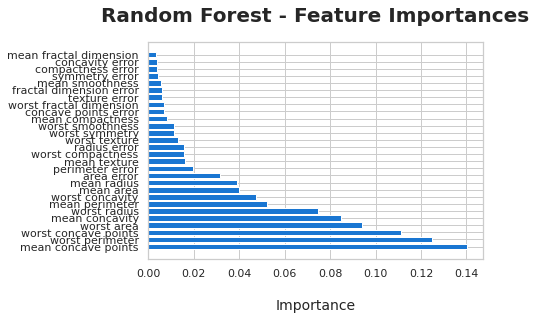

In [31]:
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['attr'] = X_train2.columns
dset['importance'] = model.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Avaliação

In [32]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 60 104]
    True Negatives:[104  60]
    False Positives:[4 3]
    False Negatives:[3 4]
    Sensibilidade / Recall:[0.95238095 0.96296296]
    Especificidade:[0.96296296 0.95238095]
    Precisao:[0.9375     0.97196262]
    Negative predictive value:[0.97196262 0.9375    ]
    Fall out:[0.03703704 0.04761905]
    False negative rate:[0.04761905 0.03703704]
    False discovery rate:[0.0625     0.02803738]
    F1 Score:[0.94488189 0.96744186]
    Acuracia:[0.95906433 0.95906433]
    CONFUSION MATRIX ------------
    [[ 60   3]
 [  4 104]]


In [33]:
balanced_accuracy_score(y_test, y_pred)

0.9576719576719577

## SVM

### Melhores Hiperparâmetros

In [34]:
from sklearn.svm import SVC

svm = SVC(random_state=0, probability=True)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
hyperparameters = dict(C=[1, 0.5, 0.1, 0.01], kernel=['linear', 'poly', 'rbf', 'sigmoid'],
                      class_weight=['balanced',None], degree=[2,3,4,5])

randomizedsearch = RandomizedSearchCV(svm, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
svm_best = randomizedsearch.fit(X_train, y_train)
print(svm_best.best_params_) # Melhores hiperparâmetros

{'kernel': 'linear', 'degree': 4, 'class_weight': 'balanced', 'C': 0.5}


### Seleção de Variáveis

In [35]:
svm_best = SVC(random_state=0, probability=True,
               kernel='linear', degree=4, class_weight='balanced', C=0.5)

model = RFECV(estimator=svm_best, step=1, cv=StratifiedKFold(5), scoring='balanced_accuracy', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 18


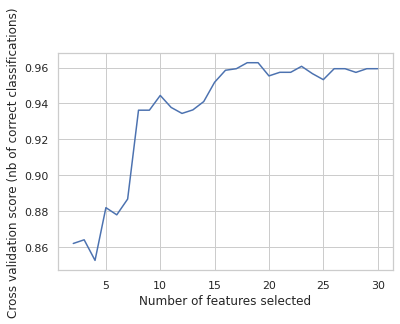

In [36]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

In [37]:
# Variáveis Selecionadas
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)
X_train2.columns

Index(['mean radius', 'mean texture', 'mean smoothness', 'mean compactness',
       'mean concavity', 'mean concave points', 'mean symmetry',
       'texture error', 'perimeter error', 'area error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry'],
      dtype='object')

In [38]:
# Coeficientes
model.estimator_.coef_

array([[ 0.78285158,  0.07725458, -0.1202344 , -0.16286125, -0.28477549,
        -0.16472898, -0.21301716,  0.7711328 ,  0.14517268, -0.08383308,
         0.21753836, -0.2599866 , -0.21556422, -0.21139299, -0.4689258 ,
        -0.99180046, -0.38675121, -0.44213378]])

In [39]:
model.estimator_.intercept_

array([15.4438487])

### Avaliação

In [40]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 62 100]
    True Negatives:[100  62]
    False Positives:[8 1]
    False Negatives:[1 8]
    Sensibilidade / Recall:[0.98412698 0.92592593]
    Especificidade:[0.92592593 0.98412698]
    Precisao:[0.88571429 0.99009901]
    Negative predictive value:[0.99009901 0.88571429]
    Fall out:[0.07407407 0.01587302]
    False negative rate:[0.01587302 0.07407407]
    False discovery rate:[0.11428571 0.00990099]
    F1 Score:[0.93233083 0.9569378 ]
    Acuracia:[0.94736842 0.94736842]
    CONFUSION MATRIX ------------
    [[ 62   1]
 [  8 100]]


In [41]:
balanced_accuracy_score(y_test, y_pred)

0.955026455026455

## RNA

### Melhores Hiperparâmetros

In [42]:
from sklearn.neural_network import MLPClassifier

rna = MLPClassifier(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
hyperparameters = dict(hidden_layer_sizes=[(50,), (100,), (150,)], activation=['identity', 'logistic', 'tanh', 'relu'],
                      solver=['lbfgs', 'sgd', 'adam'], alpha=[0.0001, 0.001, 0.01],
                      learning_rate=['constant', 'invscaling', 'adaptive'])

randomizedsearch = RandomizedSearchCV(rna, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='balanced_accuracy')
rna_best = randomizedsearch.fit(X_train, y_train)
print(rna_best.best_params_) # Melhores hiperparâmetros

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (150,), 'alpha': 0.0001, 'activation': 'logistic'}


### Avaliação

In [43]:
y_pred = rna_best.predict(X_test)

show_results(y_test, y_pred)

    True Positives:[ 60 103]
    True Negatives:[103  60]
    False Positives:[5 3]
    False Negatives:[3 5]
    Sensibilidade / Recall:[0.95238095 0.9537037 ]
    Especificidade:[0.9537037  0.95238095]
    Precisao:[0.92307692 0.97169811]
    Negative predictive value:[0.97169811 0.92307692]
    Fall out:[0.0462963  0.04761905]
    False negative rate:[0.04761905 0.0462963 ]
    False discovery rate:[0.07692308 0.02830189]
    F1 Score:[0.9375     0.96261682]
    Acuracia:[0.95321637 0.95321637]
    CONFUSION MATRIX ------------
    [[ 60   3]
 [  5 103]]


In [44]:
balanced_accuracy_score(y_test, y_pred)

0.953042328042328